In [1]:
from common import *

Using TensorFlow backend.


# Load data

In [2]:
model = gensim.models.Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))
wv = model.wv

2017-07-31 22:55:47,495 : INFO : loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-07-31 22:55:49,557 : INFO : loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-07-31 22:55:49,558 : INFO : loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-07-31 22:55:50,494 : INFO : setting ignored attribute syn0norm to None
2017-07-31 22:55:50,495 : INFO : loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-07-31 22:55:51,411 : INFO : setting ignored attribute cum_table to None
2017-07-31 22:55:51,414 : INFO : loaded ../data/vectors/w2v_model_300_w10


In [3]:
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'pure.dict'))
tfidf = models.TfidfModel.load(join(DATA_FOLDER, 'tfidf_pure.model'))
# !!!!!
tfidf.normalize= True

2017-07-31 22:55:53,242 : INFO : loading Dictionary object from ../data/pure.dict
2017-07-31 22:55:54,615 : INFO : loaded ../data/pure.dict
2017-07-31 22:55:54,616 : INFO : loading TfidfModel object from ../data/tfidf_pure.model
2017-07-31 22:55:55,042 : INFO : loaded ../data/tfidf_pure.model


In [4]:
all_docs = get_all_docs(DATA_FOLDER)
val_docs = sorted(glob(join(DATA_FOLDER, 'validate/*.txt')))

# Main funcs

In [6]:
def sim_matrix(word_set1, word_set2, wv):
    l1 = list(word_set1)
    l2 = list(word_set2)
    wv1 = wv[l1]
    wv2 = wv[l2]
    
    arr = cosine_similarity(wv1, wv2)
    
    smat = pd.DataFrame(arr, index=l1, columns=l2)
    return smat
    

In [7]:
def wmd(smat, tfidf_weights):
    maxs = np.amax(smat, axis=0)
    return np.dot(maxs, tfidf_weights)

In [8]:
def get_test_tfidf_weights(val_docs, wv):
    tweights = {}
    for fname in tqdm(val_docs):
        with open(fname, 'r') as f:
            doc_text = f.read()
        tokenized_filtered = [w for w in tokenize(doc_text) if w in wv]
        doc_bow = dictionary.doc2bow(tokenized_filtered)
        sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
        sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                                   columns=['word', 'score'])
        
        name = path.splitext(basename(fname))[0]
        tweights[name] = sorted_tfidf
            
    return tweights

In [9]:
tweights = get_test_tfidf_weights(val_docs, wv)
val_words = set(pd.concat([v.word for v in tweights.values()]))
ziped_files = sorted(glob(DATA_FOLDER + '/documents/*.gz'), key=natural_keys)

100%|██████████| 130/130 [00:00<00:00, 197.61it/s]


In [10]:
# tweights['_01_98_2010120931A10010101RU']

In [11]:
def doc_queries_distances(d_smat, tweights):
    dists = []
    for k, query in tweights.items():
        if len(query) == 0:
            dists.append(None)
            continue
        
        qsmat = d_smat.loc[:, query.word]
        dist = wmd(qsmat, query.score)
        dists.append(dist)
    return dists


def _calc(docs):        
    doc_dists = []
    words = set([w for doc in docs for sent in doc for w in sent if w in wv])
    smat = sim_matrix(words, val_words, wv)
    for doc in tqdm(docs):
        doc_words = set([w for sent in doc for w in sent])
        d_smat = smat.loc[doc_words, :]
        dists = doc_queries_distances(d_smat, tweights)

        doc_dists.append(dists)
    return doc_dists


def calc_dists(fnames, wv):
    doc_dists = []
    for fn in fnames:
        print(fn)
        ! echo {fn} >> ../data/out
        with GzipFile(fn, 'r') as myzip:
            text = myzip.read()
        docs = json.loads(text)
        
        parallelizer = Parallel(n_jobs=cpu_count)

        # this iterator returns the functions to execute for each task
        tasks_iterator = ( delayed(_calc)(docs_block) for 
                          docs_block in grouper(len(docs)//cpu_count, docs) )  
        result = parallelizer( tasks_iterator )        
        doc_dists += result
            
    return np.array(sum(doc_dists, []))

In [128]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:49<00:00,  4.37it/s]


In [132]:
np.save(join(DATA_FOLDER, 'val_dists.npy'), val_dists)

In [136]:
val_dists = np.load(join(DATA_FOLDER, 'val_dists.npy'))

In [137]:
sorted_args = val_dists.argsort(axis=0)[-20000000:][::-1]

In [138]:
sorted_args

array([[  20,    0,  857, ..., 1121,  778,  759],
       [ 563,  474,  563, ..., 1122,  792,  876],
       [ 857,   20,  482, ...,  792,  625, 1012],
       ..., 
       [ 327,  327, 1028, ...,  915, 1028,  313],
       [1044,  583,  327, ..., 1028, 1175, 1175],
       [1028, 1044, 1044, ..., 1192, 1192, 1028]])

In [142]:
send_email(notebook_url, body='Finished')

Successfully sent email


TODO:
* normalize = False in tfidf
* first 2-3 sents of query

# Check

In [27]:
! cat {all_docs[20]}

способ изготовление портландцемент и способ изготовление бетонный и железобетонный изделие на основа изготовлять портландцемент  . 
 изобретение относиться к технология строительный материал и мочь быть использовать для производство цемент и изделие из бетон .
 сущность изобретение заключаться в том , что в способ изготовление цемент , включать получение алитовый портландцементный клинкер обжиг исходный сырьевой смесь до спекание во вращать печь с введение добавка портландцемент в количество 0,05 - 5% масса клинкер с последующий охлаждение клинкер и помол о совместно с гипсовый компонент , в цементный сырьевой смесь дополнительно вводить цементный пыль , улавливать из отходить печной газ , при первоначальный разность λ значение коэффициент насыщение сырьевой смесь и пыль 0,2 - 0,4 , добавка портландцемент сначала вводить в количество 0,05 мас . % , затем увеличивать ее содержание в 1,5 - 5 раз до получение l в предел 0,1 - 0,15 , далее , не менять подача добавка портландцемент , увелич

In [17]:
! cat {val_docs[0]}

﻿способ экономия электроэнергия .
 изобретение относиться к проблема экономия электроэнергия , как один из весомый в программа борьба с глобальный потепление климат , и эффективный мочь быть применять , как это ни показаться неожиданный , в область кулинарный хозяйство .
 проблема с электроэнергия возникнуть сразу же после изобретение в 1879 г . гениальный томас альва эдисон электрический лампа накаливание .
 при ее запиток от использовать тогда источник постоянный ток , недопустимый большой быть потеря в линия передача на большой расстояние .
 проблема быть устранять в 1887 г . один из великий физик современность никола теслый , свой изобретение генератор переменный ток и высоковольтный трансформатор .
 дальнейший нововведение , как и этот , подстраиваться , в основной , к электрический характеристика объект запиток , как правило не учитывать они физический особенность .
 в кулинария экономия затрачивать энергия не являться главенствующий фактор , но неизменный оставаться только стрем

In [29]:
val_docs[0]

'../data/validate/_01_98_2010120931A10010101RU.txt'

In [52]:
tweights['_01_98_2010120931A10010101RU']

,word,score
0,экономия,0.419251
1,кулинария,0.253144
2,электроэнергия,0.234901
3,томить,0.218281
4,блюдо,0.196800
5,старинный,0.183828
6,запиток,0.150455
7,кухня,0.134959
8,настаивать,0.132950
9,бытовой,0.130700


In [30]:
doc = docs[20]
words = set([w for s in doc for w in s if w in wv])
smat = sim_matrix(words, val_words, wv)

query = tweights['_01_98_2010120931A10010101RU']
qsmat = smat.loc[:, query.word]
dist = wmd(qsmat, query.score)
dist


6.8542057125763431

In [34]:
qsmat

,экономия,кулинария,электроэнергия,томить,блюдо,старинный,запиток,кухня,настаивать,бытовой,...,необходимый,скорость,выбирать,проводить,давление,вода,температура,область,технический,отличать
максимальный,0.329550,0.143664,0.280366,0.186835,0.127288,0.092638,0.226317,0.179365,0.142955,0.169375,...,0.445278,0.461912,0.161289,0.179179,0.249985,0.279526,0.255009,0.164643,0.249031,0.262290
необходимый,0.490644,0.158346,0.374009,0.194488,0.169835,0.202692,0.347426,0.198806,0.196741,0.198438,...,1.000000,0.321149,0.192062,0.288027,0.275092,0.326664,0.309743,0.189611,0.450288,0.380760
тело,0.187187,0.174066,0.233342,0.175171,0.087783,0.175663,0.154676,0.084250,0.182823,0.222012,...,0.205481,0.164726,0.080573,0.158673,0.247280,0.199655,0.173734,0.211206,0.124615,0.241783
сборный,0.288200,0.206711,0.244770,0.190817,0.149871,0.245866,0.192113,0.253114,0.162944,0.230339,...,0.243868,0.139586,0.121047,0.134577,0.186776,0.217245,0.136334,0.158719,0.266966,0.258378
ион,0.120949,0.123141,0.179567,0.176582,0.127696,0.051442,0.185909,0.092549,0.072776,0.096666,...,0.236569,0.195612,0.205079,0.194239,0.182981,0.293790,0.209849,0.157090,0.135724,0.158080
const,0.175193,0.009503,0.185565,0.075169,0.013069,0.094145,0.298383,0.014452,0.075664,0.104798,...,0.315752,0.407424,0.027778,0.114847,0.212377,0.124565,0.171561,0.093823,0.152570,0.123456
служащий,0.301613,0.168887,0.338700,0.219254,0.166997,0.187006,0.343176,0.231763,0.174045,0.316894,...,0.477698,0.207793,0.171568,0.231330,0.243284,0.237125,0.216598,0.296982,0.336508,0.494295
проблема,0.412924,0.259764,0.305099,0.162332,0.160875,0.257945,0.159802,0.228491,0.167944,0.306755,...,0.406851,0.192511,0.074332,0.171127,0.144422,0.197207,0.168458,0.265243,0.422906,0.169044
промышленность,0.325743,0.377734,0.227040,0.173172,0.169196,0.301691,0.104565,0.185355,0.108154,0.344056,...,0.309999,0.161825,0.070174,0.187414,0.172864,0.233869,0.228327,0.235362,0.436656,0.265247
свободно,0.154730,0.181977,0.212237,0.167730,0.087168,0.164016,0.155261,0.130078,0.179986,0.154106,...,0.311306,0.263833,0.085340,0.142188,0.181345,0.208207,0.168544,0.181388,0.194527,0.317860


In [58]:
qsmat['водитель'].argmax()

'транспортный'

In [53]:
maxs = np.amax(qsmat, axis=0)
# maxs.sort_values(ascending=False)
maxs
# np.dot(maxs, tfidf_weights)

экономия              1.000000
кулинария             0.377734
электроэнергия        1.000000
томить                0.557017
блюдо                 0.407746
старинный             0.399344
запиток               0.455162
кухня                 0.425486
настаивать            0.451680
бытовой               0.453349
альва                 0.459763
кипение               0.563609
электронагреватель    0.576168
гениальный            0.522256
плита                 1.000000
приготовление         1.000000
смелый                0.495848
водитель              0.694665
электр                0.361081
кулинарный            0.427609
главенствующий        0.467579
эдисон                0.401472
прерывание            0.550386
одноразовость         0.549095
современность         0.646705
показаться            0.465965
томас                 0.361320
нововведение          0.494437
превзойти             0.610479
весомый               0.564269
                        ...   
фактор                1.000000
рассматр

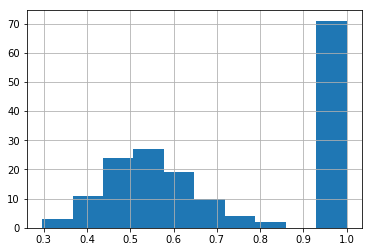

count    171.000000
mean       0.734431
std        0.238098
min        0.296096
25%        0.519407
50%        0.649917
75%        1.000000
max        1.000000
dtype: float64


In [45]:
maxs.hist()
plt.show()
print(maxs.describe())


# First n

In [19]:
# fn = join(DATA_FOLDER, 'first2.json.gz')

# with GzipFile(fn, 'r') as myzip:
#     text = myzip.read()
# docs = json.loads(text)
# del text

In [26]:
fn = join(DATA_FOLDER, 'first3_val.json.gz')

with GzipFile(fn, 'r') as myzip:
    text = myzip.read()
val_documents = json.loads(text)
del text

In [27]:
len(val_documents)

130

In [47]:
tweights = {}
for fname, doc in tqdm(zip(val_docs, val_documents)):
    tokenized_filtered = [w for w in doc if w in wv]
    doc_bow = dictionary.doc2bow(tokenized_filtered)
    sorted_tfidf = sorted(tfidf[doc_bow], key=itemgetter(1), reverse=True)
    sorted_tfidf = pd.DataFrame([(dictionary[k],v) for k,v in sorted_tfidf],
                               columns=['word', 'score'])

    name = path.splitext(basename(fname))[0]
    tweights[name] = sorted_tfidf

val_words = set(pd.concat([v.word for v in tweights.values()]))

130it [00:00, 1610.34it/s]


In [48]:
val_dists = calc_dists(ziped_files[:1], wv)

../data//documents/0.json.gz


100%|██████████| 298/298 [01:56<00:00,  4.08it/s]
